# Sina Weibo prediction

In [1]:
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

RANDOM_STATE=8402
CV_SPLITS=5

2024-04-19 08:13:53.859259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-04-19 08:13:53.859431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-04-19 08:13:54.034308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Defining the loss function

In [2]:
def mixed_loss(y_true: ArrayLike, y_pred: ArrayLike, bias=[5,3,3], scaling=[.5,.25,.25], thresold=.8):
    precision = 1 - np.sum((np.abs(y_pred-y_true)/(y_true + bias)) * scaling, axis=1)
    sgn_precision = precision > thresold
    count_row_sum = np.sum(np.clip(y_true, a_min=None, a_max=100), axis=1) + 1
    return np.sum(count_row_sum * sgn_precision) / np.sum(count_row_sum)

mixed_scorer = make_scorer(mixed_loss, greater_is_better=True)

## Dataset preperation

In [3]:
def file_to_df(filename, col_names=['uid', 'mid', 'ts', 'forward_n', 'comment_n', 'like_n', 'content']):
    """Helper to parse data. Contains hardcoded logic"""
    df = pd.read_csv(filename, sep='\t', names=col_names)
    if 'ts' in col_names:
        df['ts'] = pd.to_datetime(df['ts'])
    return df

In [4]:
Xy_tv = file_to_df('/kaggle/input/sna-weibo-data/Weibo Data/weibo_train_data(new)/weibo_train_data.txt')
X_tv = Xy_tv.drop(['forward_n', 'comment_n', 'like_n'], axis=1)
y_tv = Xy_tv[['forward_n', 'comment_n', 'like_n']].replace([np.inf, -np.inf], np.nan)

## Data analysis

### Navive analysis

In [5]:
def embedd(
    data,
    vectorizer=TfidfVectorizer(stop_words='english', max_features=250),
    reducer=umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2)
):
    embeddings = vectorizer.fit_transform(data)
    return reducer.fit_transform(embeddings)


In [6]:
embeddings = embedd(X_tv.content.sample(100_000, random_state=RANDOM_STATE))

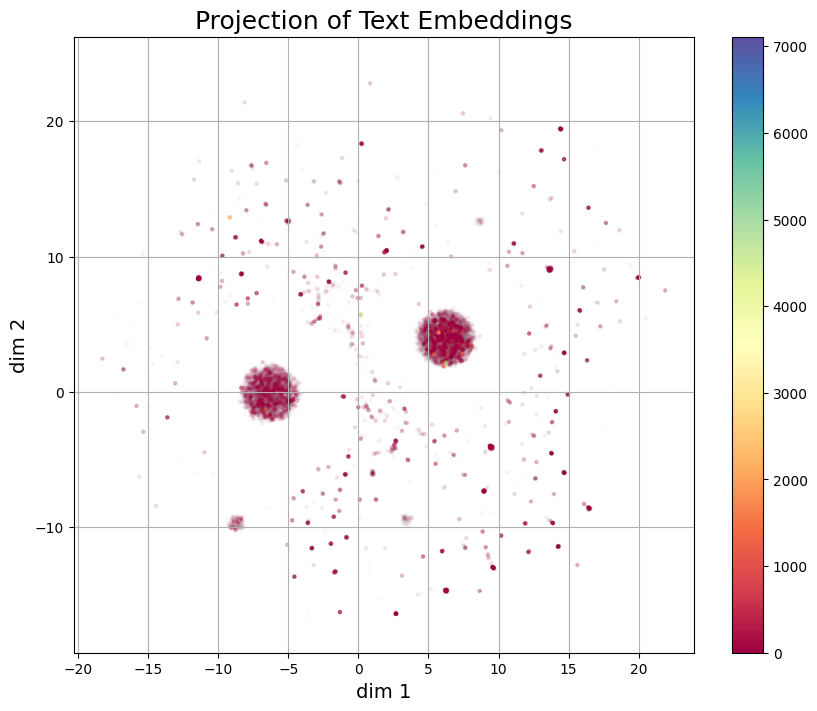

In [7]:
categories = np.sum(y_tv.sample(100_000, random_state=RANDOM_STATE) * [.5, .25, .25], axis=1)
alhpa_vals = np.log10(categories / categories.max() + 0.01) / np.log10(1.01)
scaled_alpha_vals = np.clip((alhpa_vals - alhpa_vals.min()) / (alhpa_vals.max() - alhpa_vals.min()), a_min=None, a_max=1)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=categories,
    cmap='Spectral',
    s=5,
    alpha=scaled_alpha_vals
)
plt.colorbar(scatter)
plt.title('Projection of Text Embeddings', fontsize=18)
plt.xlabel('dim 1', fontsize=14)
plt.ylabel('dim 2', fontsize=14)
plt.grid(True)
plt.show()

### Target analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):


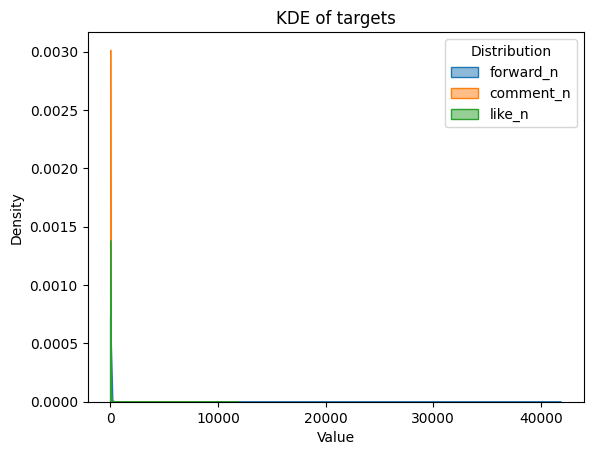

In [8]:
for column in y_tv.columns:
    sns.kdeplot(y_tv[column], label=column, fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of targets')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Distribution')

## Model definition

In [9]:
models: list[tuple[str,BaseEstimator]] = [
    ('base-0', DummyRegressor(strategy='constant', constant=[0,0,0])),
    ('sd', 'sd')
]

## Eval

In [10]:
ts_cv = TimeSeriesSplit(n_splits=CV_SPLITS)

In [11]:
scores = {n: cross_val_score(
    m,
    X_tv.sample(100_000, random_state=RANDOM_STATE),
    y_tv.sample(100_000, random_state=RANDOM_STATE),
    cv=ts_cv,
    scoring=mixed_scorer
) for n, m in models}

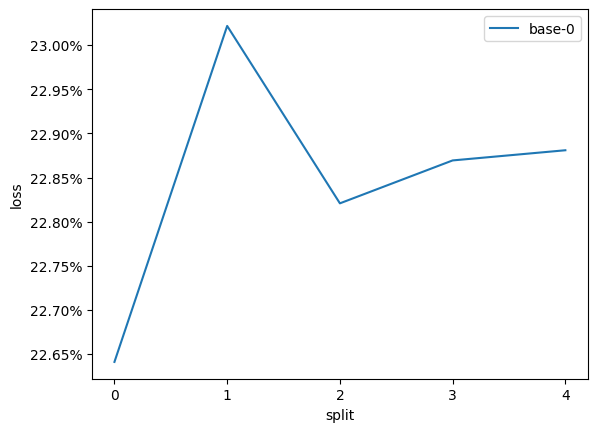

In [12]:
ax = pd.DataFrame(scores).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.set_xticks(np.arange(CV_SPLITS))
ax.set_ylabel('loss')
_ = ax.set_xlabel('split')